#### 자전거 대여 수요 예측

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [3]:
def data_load(dataName, n=5):
    baseFolder='c:/data/bike_sharing/'
    df = pd.read_csv(baseFolder+dataName)
    display(df.head(n))
    df.info()

data_load('bike_train.csv')

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [4]:
baseFolder='c:/data/bike_sharing/'
bike_df = pd.read_csv(baseFolder+'bike_train.csv')

##### 데이터 전처리 및 시각화

In [5]:
#bike_df['datetime'] = bike_df['datetime'].astype('str') # 'datetime'의 datatype이 int형인 경우 수행
# 이 자료에서 datetime은 object형이므로 str 변환 할 필요 x 
bike_df['datetime'] = pd.to_datetime(bike_df['datetime'])
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [6]:
# year, month, day, hour 따로 추출하여 column 추가 ===> 함수화 시켜보기
bike_df['year']=bike_df.datetime.apply(lambda x : x.year)
bike_df['month']=bike_df.datetime.apply(lambda x : x.month)
bike_df['day']=bike_df.datetime.apply(lambda x : x.day)
bike_df['hour']=bike_df.datetime.apply(lambda x : x.hour)

bike_df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [7]:
bike_df.drop(labels='datetime', axis=1,inplace=True)
#bike_df.info()

In [8]:
# casual, registered는 필요없는 데이터이므로 삭제

drop_c = ['casual', 'registered']
bike_df=bike_df.drop(labels=drop_c, axis=1)
bike_df.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2


In [9]:
x_df=bike_df.loc[:, [col for col in bike_df.columns if col != 'count']]
x_df.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'year', 'month', 'day', 'hour'],
      dtype='object')

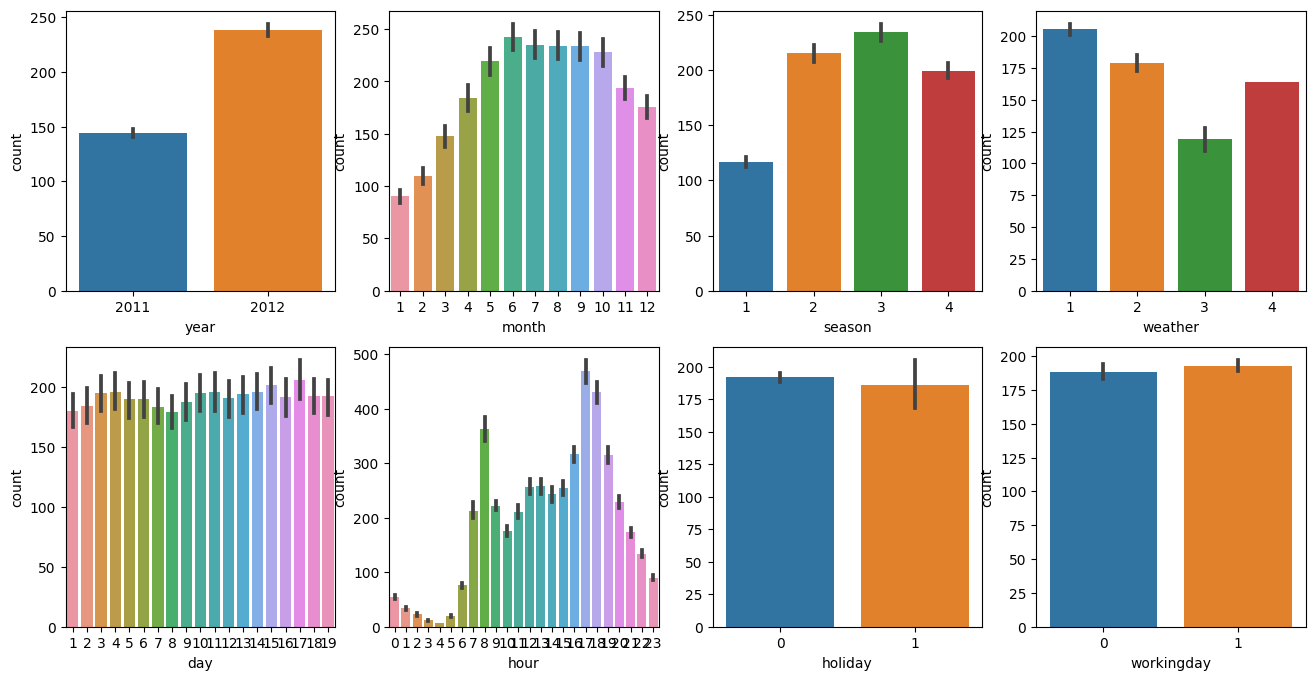

In [10]:
# target 값인 count와 그 외 column들 간의 관계 분석 (시각화)

fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
cat_features = ['year', 'month','season','weather','day', 'hour', 'holiday','workingday']
# cat_features에 있는 모든 칼럼별로 개별 칼럼값에 따른 count의 합을 barplot으로 시각화
for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i%4
    # 시본의 barplot을 이용해 칼럼값에 따른 count의 합을 표현
    sns.barplot(x=feature, y='count', data=bike_df, ax=axs[row][col])

plt.savefig('c:/data/bike_sharing/plt_img')

In [33]:
print(bike_df[bike_df['season'] == 1].month.unique())
print(bike_df[bike_df['season'] == 2].month.unique())
print(bike_df[bike_df['season'] == 3].month.unique())
print(bike_df[bike_df['season'] == 4].month.unique())

[1 2 3]
[4 5 6]
[7 8 9]
[10 11 12]


In [11]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   count       10886 non-null  int64  
 9   year        10886 non-null  int64  
 10  month       10886 non-null  int64  
 11  day         10886 non-null  int64  
 12  hour        10886 non-null  int64  
dtypes: float64(3), int64(10)
memory usage: 1.1 MB


In [18]:
tmp=bike_df.iloc[:,[0,3,8,9,10,12]]
bike_corr=tmp.corr()
bike_corr

,season,weather,count,year,month,hour
season,1.000000,0.008879,0.163439,-0.004797,0.971524,-0.006546
weather,0.008879,1.000000,-0.128655,-0.012548,0.012144,-0.022740
count,0.163439,-0.128655,1.000000,0.260403,0.166862,0.400601
year,-0.004797,-0.012548,0.260403,1.000000,-0.004932,-0.004234
month,0.971524,0.012144,0.166862,-0.004932,1.000000,-0.006818
hour,-0.006546,-0.022740,0.400601,-0.004234,-0.006818,1.000000


<Axes: >

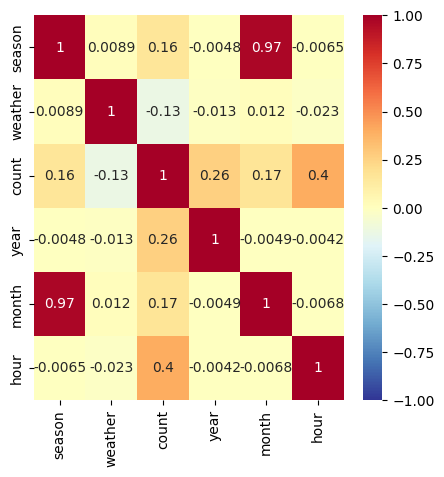

In [17]:
plt.figure(figsize=(5,5))
sns.heatmap(bike_corr, annot=True, cmap='RdYlBu_r', vmin=-1, vmax=1)

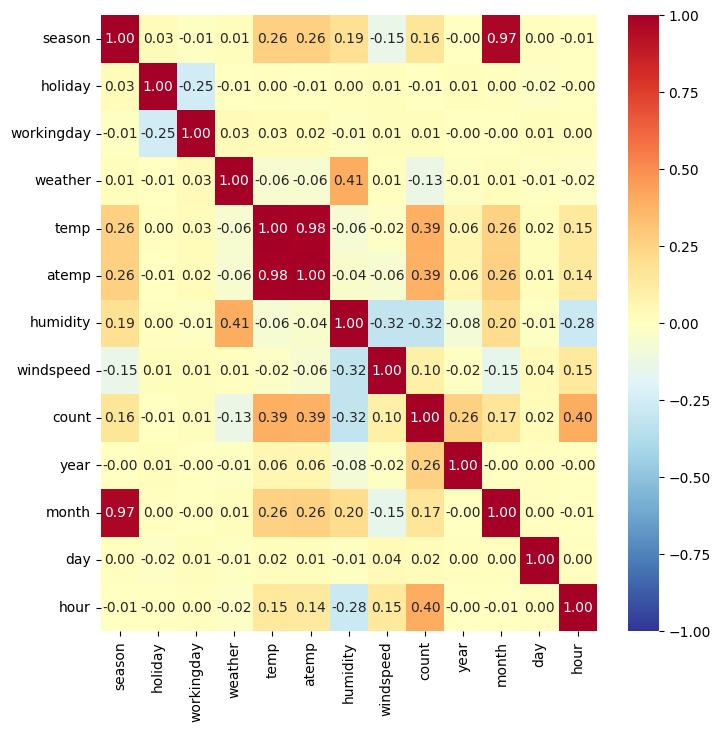

In [22]:
bike_cor = bike_df.corr()
plt.subplots(figsize=(8,8))
sns.heatmap(bike_cor, annot=True, fmt='.2f',cmap='RdYlBu_r', vmin=-1, vmax=1)
plt.savefig('c:/data/bike_sharing/corr_img')

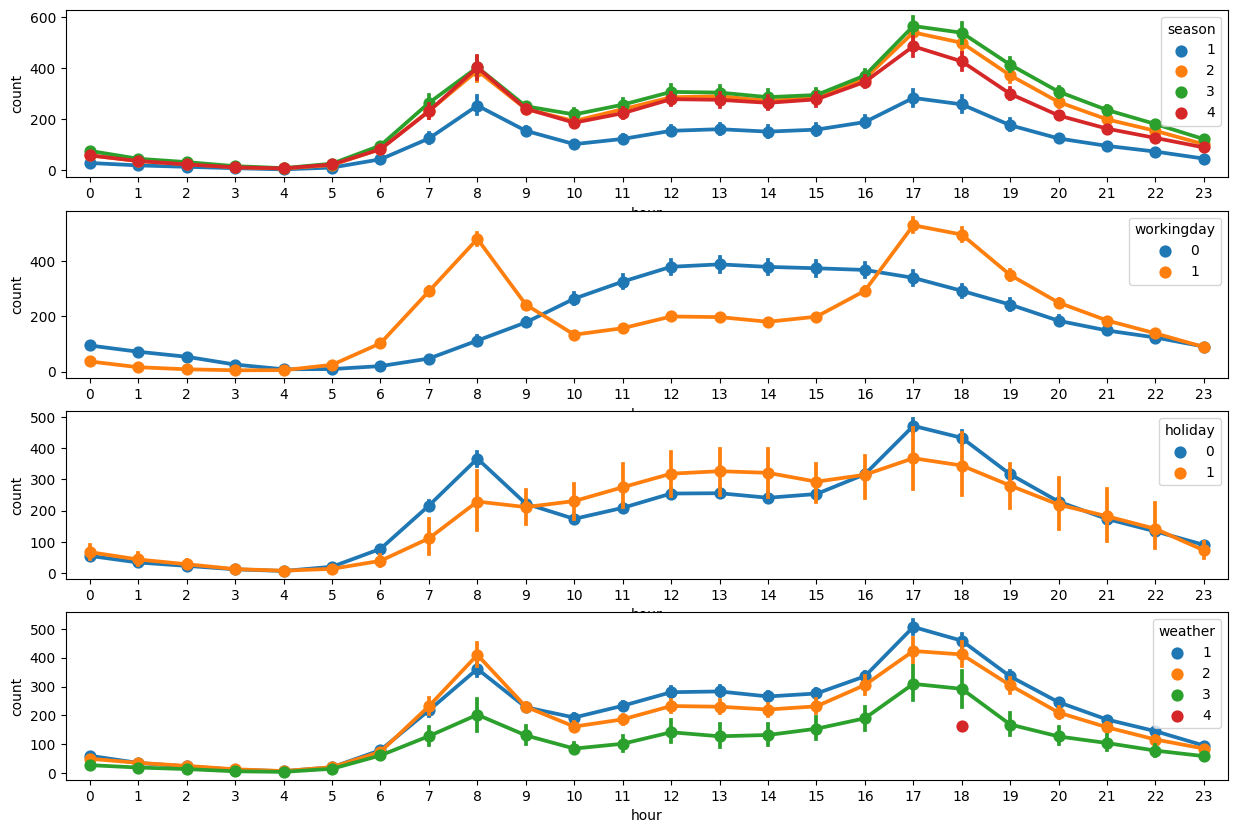

In [32]:
# 카테고리형 변수 확인
plt.figure(figsize=(15,10))
plt.subplot(4,1,1)
sns.pointplot(data=bike_df, x='hour', y='count', hue='season')

plt.subplot(4,1,2)
sns.pointplot(data=bike_df, x='hour', y='count', hue='workingday')

plt.subplot(4,1,3)
sns.pointplot(data=bike_df, x='hour', y='count', hue='holiday')

plt.subplot(4,1,4)
sns.pointplot(data=bike_df, x='hour', y='count', hue='weather')

plt.savefig('c:/data/bike_sharing/corr_img')

<Axes: xlabel='humidity', ylabel='count'>

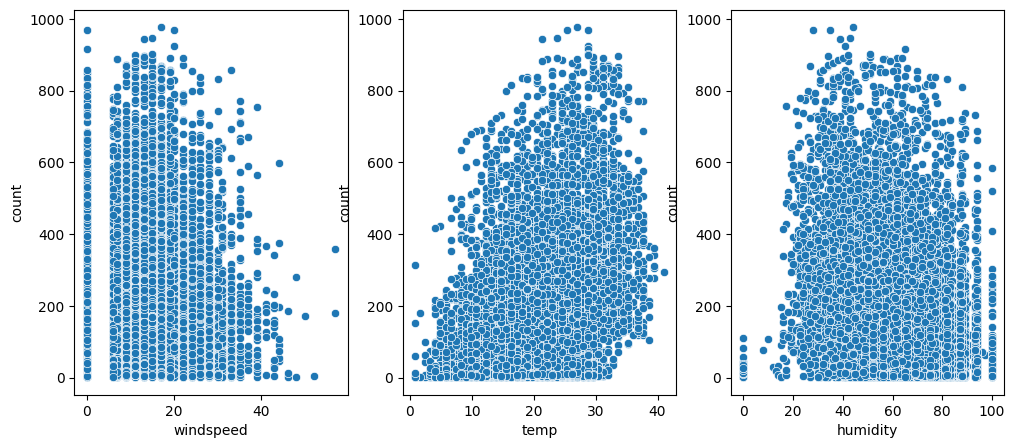

In [35]:
# 연속형 변수 확인
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize=(12,5))

sns.scatterplot(data = bike_df, x = 'windspeed', y = 'count', ax = ax1)
sns.scatterplot(data = bike_df, x = 'temp', y = 'count', ax = ax2)
sns.scatterplot(data = bike_df, x = 'humidity', y =  'count', ax = ax3)

In [36]:
len(bike_df[bike_df['windspeed']==0]) 
# 바람세기가 0인 데이터 수 : 1313  -> 이상치 제거 과정이 필요함

1313

In [57]:
from sklearn.ensemble import RandomForestClassifier
def predict_windspeed(data):
    wind0 = data.loc[data['windspeed']==0]
    windnot0=data.loc[data['windspeed']!=0]

    #풍속이 날씨변수이기 때문에 날씨변수를 활용해서 windspeed를 예측해줄 것
    col = ['season', 'weather', 'temp', 'humidity', 'atemp', 'day']
    windnot0['windspeed'] = windnot0['windspeed'].astype('str')
    
    rf = RandomForestClassifier()
    #windspeed가 0이 아닌 컬럼으로 fit 해줌
    #model.fit(X_train, y_train)
    rf.fit(windnot0[col], windnot0['windspeed'])
 
 	#windspeed가 0인 부분을 예측
    #model.predict(X_test)
    pred_wind0 = rf.predict(X = wind0[col])
    
    #wind0의 windspeed 값을 pred_wind0으로 바꿔주고
    wind0['windspeed'] = pred_wind0
    
    #windnot0과 wind0을 합쳐준다
    data = windnot0.append(wind0)
    data['windspeed'] = data['windspeed'].astype('float')
    
    data.reset_index(inplace = True)
    data.drop("index", inplace = True, axis = 1)
   
    return data